In [1]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
x = np.linspace(-4, 4, 201).reshape(-1,1)
x = np.concatenate([x, x], 1)
y =[]
for i in range(len(x)):
    y.append( [np.cos(x[i,0])+0.1*x[i,1]**2, np.sin(x[i,1])+x[i,0]**3]   )
y = np.array(y)

idx = np.random.permutation(np.arange(len(x)))
test_ratio=0.2
train_x = x[idx[int(test_ratio*len(x)):]]
train_y = y[idx[int(test_ratio*len(x)):]]
test_x  = x[idx[:int(test_ratio*len(x))]]      
test_y  = y[idx[:int(test_ratio*len(x))]]      
print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

(161, 2) (161, 2)
(40, 2) (40, 2)


In [3]:
import torch
from torch.utils.data import DataLoader, TensorDataset
class NN:
    def __init__(self, inputs, targets, hidden_num=256):

        self.inputs  = inputs
        self.targets = targets
        
        self.pca = PCA(whiten=True)
        self.sc  = StandardScaler()
        self.pca.fit(inputs)
        self.sc.fit(targets)
        self.inputs  = self.pca.transform(inputs)
        self.targets = self.sc.transform(targets)
        
        self.model = torch.nn.Sequential(
            torch.nn.Linear(inputs.shape[1], hidden_num),
            torch.nn.SiLU(),
            torch.nn.Linear(hidden_num, hidden_num),
            torch.nn.SiLU(),    
            torch.nn.Linear(hidden_num, hidden_num),
            torch.nn.SiLU(),    
            torch.nn.Linear(hidden_num, hidden_num),
            torch.nn.SiLU(),    
            torch.nn.Linear(hidden_num, targets.shape[1])
        )
        
    def train(self, holdout_ratio=0.1, early_stop=10):
        idx = np.random.permutation(np.arange(len(self.inputs)))
        inputs_t = self.inputs[idx[int(holdout_ratio*len(self.inputs)):]]
        inputs_v = self.inputs[idx[:int(holdout_ratio*len(self.inputs))]]        
        targets_t = self.targets[idx[int(holdout_ratio*len(self.inputs)):]]
        targets_v = self.targets[idx[:int(holdout_ratio*len(self.inputs))]]
        
        dataset_t = TensorDataset(torch.from_numpy(inputs_t.astype(np.float32)), torch.from_numpy(targets_t.astype(np.float32)))
        loader_t  = DataLoader(dataset_t, batch_size=32, shuffle=True, drop_last=False)

        dataset_v = TensorDataset(torch.from_numpy(inputs_v.astype(np.float32)), torch.from_numpy(targets_v.astype(np.float32)))
        loader_v  = DataLoader(dataset_v, batch_size=32, shuffle=True, drop_last=False)
        
        criterion = torch.nn.MSELoss() 
        optimizer = torch.optim.Adam(self.model.parameters(), lr = 0.001)
        
        cnt=0
        best_valid_loss=1e10
        for i in range(10000):    
            train_loss=[]
            for x_t,y_t in loader_t:
                optimizer.zero_grad() 
                loss = criterion(self.model(x_t), y_t)
                loss.backward() 
                optimizer.step()
                train_loss.append(loss.item())

            valid_loss=[]
            for x_v,y_v in loader_t:
                with torch.no_grad():
                    loss = criterion(self.model(x_v), y_v)
                    valid_loss.append(loss.item())
        
            train_loss=sum(train_loss)/len(train_loss)
            valid_loss=sum(valid_loss)/len(valid_loss)

            if best_valid_loss>valid_loss:
                best_valid_loss=valid_loss
                cnt=0
            else:
                cnt+=1

            print(i,cnt,best_valid_loss,valid_loss)
                
            if cnt>=early_stop:
                break

    def predict(self, inputs):
        inputs_pca = self.pca.transform(inputs)
        with torch.no_grad():
            targets_sc = self.model(torch.from_numpy(inputs_pca.astype(np.float32)))
        return self.sc.inverse_transform(targets_sc.numpy())

In [4]:
reg = NN(x,y)

In [5]:
reg.train()

0 0 0.6101055641969045 0.6101055641969045
1 0 0.5605845252672831 0.5605845252672831
2 1 0.5605845252672831 0.5915094266335169
3 0 0.5482933123906454 0.5482933123906454
4 0 0.5310294330120087 0.5310294330120087
5 0 0.5057256668806076 0.5057256668806076
6 0 0.5045635451873144 0.5045635451873144
7 0 0.48233823478221893 0.48233823478221893
8 0 0.47598238786061603 0.47598238786061603
9 0 0.4440518220265706 0.4440518220265706
10 0 0.4004242519537608 0.4004242519537608
11 0 0.3291851878166199 0.3291851878166199
12 0 0.19587538142999014 0.19587538142999014
13 0 0.09460631820062797 0.09460631820062797
14 1 0.09460631820062797 0.10622946793834369
15 0 0.08103191914657752 0.08103191914657752
16 0 0.05441795693089565 0.05441795693089565
17 0 0.034055604288975395 0.034055604288975395
18 0 0.02267588519801696 0.02267588519801696
19 1 0.02267588519801696 0.02774458813170592
20 0 0.018483880596856277 0.018483880596856277
21 0 0.009020130227630338 0.009020130227630338
22 0 0.004547532298602164 0.004547

In [6]:
test_pred = reg.predict(test_x)

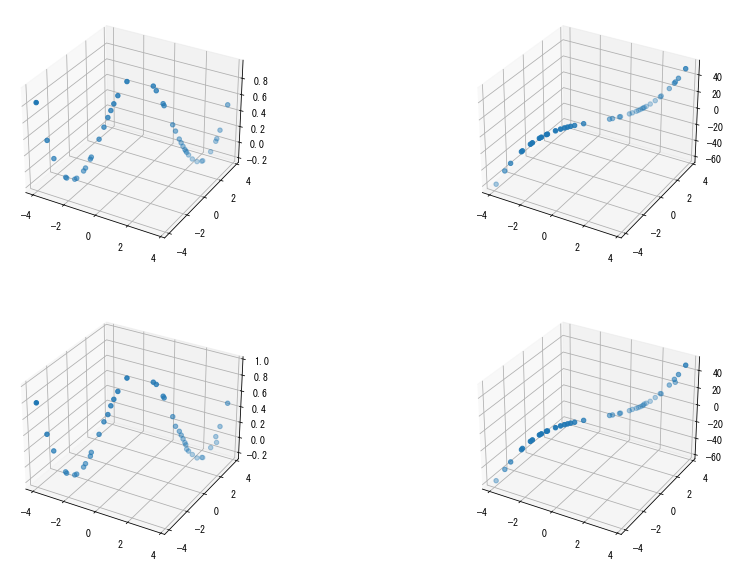

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = (15.0, 10.0)
plt.rcParams['font.family'] = "MS Gothic"

fig = plt.figure()

ax1 = fig.add_subplot(2, 2, 1, projection='3d')
ax1.scatter(test_x[:,0], test_x[:,1], test_y[:,:1])

ax2 = fig.add_subplot(2, 2, 2, projection='3d')
ax2.scatter(test_x[:,0], test_x[:,1], test_y[:,1:])

ax3 = fig.add_subplot(2, 2, 3, projection='3d')
ax3.scatter(test_x[:,0], test_x[:,1], test_pred[:,:1])

ax4 = fig.add_subplot(2, 2, 4, projection='3d')
ax4.scatter(test_x[:,0], test_x[:,1], test_pred[:,1:])